# Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

plt.style.use('seaborn')

Resources:
- [statsmodels.org example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d) - how the Shopify Risks-Algorithms team uses Quantile Regression to decide eligibility for cash advances.
- [Quantile Regression versus other techniques](http://naes.unr.edu/shoemaker/teaching/NRES-746/QuantileRegression.html) - comparison (using R) of quantile regression to OLS and ANOVA, and more about goodness of fit
- [Fitting models using R-style formulas](http://www.statsmodels.org/devel/example_formulas.html)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model

# Overview

How does ordinary least squares treat outliers? The same it treats everything - it squares them! But for outliers, squaring dramatically increases their already outsized impact on statistics like the mean.

We know from descriptive statistics that the median is more robust to outliers than the mean. This insight can serve us in predictive statistics as well, and is precisely what quantile regression is about - estimating the median (or other quantile) instead of the mean. By picking any specific quantile threshold, we can both mitigate outliers and tune our false positive/negative tradeoff. We can also deal with situations where the problem really does call for more of a quantile cutoff - safe birth weight for a baby, skill level for top competitive eSports players, etc.

**Quantiles** are cut points dividing the range of a probability distribution into continuous intervals with equal probabilities. A cut at any given percent is a **percentile**, the most common cut being the median (50th percentile). **Quartiles** are formed by 3 cuts (25th, 50th, and 75th percentiles), often used in box plots.

Quantile regression is then simply regression, like ordinary least squares, but where instead of minimizing the sum of square errors you minimize the sum of absolute error from the chosen quantile cut point (this is **very** over-simplified, see the [Wikipedia](https://en.wikipedia.org/wiki/Quantile_regression#Intuition)). If `q=0.50` (the median), then you are doing a special case of quantile regression - **least absolute deviation** (since the median is the central quantile).

Why choose any other quantile? You’ll inevitably have more error, but by tuning `q` you can choose a threshold appropriate for balancing false positives and false negatives specific to your problem. You can also model and estimate specific thresholds, such as the minimum healthy baby birth weight as assigned in the lecture notebook.

# Example 1

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [52]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00381/PRSA_data_2010.1.1-2014.12.31.csv')
print(df.shape)

df.head()

(43824, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [53]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


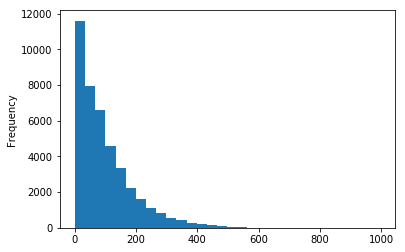

In [54]:
df['pm2.5'].plot.hist(bins=30); 

#### Linear Regression

In [55]:
# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('pm2.5', axis='columns')
y = df['pm2.5']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2590006399659862

Not bad - but what if we wanted to model the distribution more conservatively?

#### StatsModel Quantile Regression

Quantile Regression is a somewhat less common model, but it is provided by the StatsModel Python library. This library is clearly inspired by R, and borrows various syntax and API decisions from it.

StatsModel uses a slightly different paradigm than scikit-learn. As with scikit-learn you generate a model object that then exposes a .fit() method to actually train and predict.

However, scikit-learn models generally take data (as an X matrix and y array) as arguments to .fit(), while StatsModel has its model specified as a formula given to the model object at instantiation. The formula is a string of the form:

```y ~ x1 + x2 + ...```

You can specify polynomial and interaction terms flexibly, e.g.:

```y ~ x1 + (x1 * x1) + x2 + x3 + (x2 * x3)```

Also different jargon/API in StatsModel documentation:
* "endogenous" response var is dependent (y), it is "inside"
* "exogenous" variables are independent (X), it is "outside"

In [56]:
# formulas break with . in variable name, so lets change that
df = df.rename(index=str, columns={'pm2.5': 'pm25'})

# Now let's construct the formula string using all columns
quant_formula = 'pm25 ~ ' + ' + '.join(df.drop('pm25', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=0.5) # Least absolute deviation
quant_reg.summary()  # "summary" is another very R-thing

pm25 ~ No + year + month + day + hour + DEWP + TEMP + PRES + Iws + Is + Ir


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.1600
Model:                       QuantReg   Bandwidth:                       8.276
Method:                 Least Squares   Sparsity:                        133.8
Date:                Wed, 27 Feb 2019   No. Observations:                41757
Time:                        15:00:20   Df Residuals:                    41745
                                        Df Model:                           11
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004   1.67e-05     22.781      0.000       0.000       0.000
No          1.276e-07   2.67e-05      0.005      0.996   -5.23e-05    5.25e-05
year           0.8831      0.031     28.632      0.000       0.823       0.944
month         -1.4111      0.103    -13.750      0.000      -1.612      -1.210
day            0.4462      0.037     11.954      0.000       0.373       0.519
hour           1.2805      0.050     25.768      0.000       1.183       1.378
DEWP           3.6361      0.047     77.309      0.000       3.544       3.728
TEMP          -4.7104      0.060    -78.775      0.000      -4.828      -4.593
PRES          -1.6267      0.061    -26.761      0.000      -1.746      -1.508
Iws           -0.1541      0.007    -21.786      0.000      -0.168      -0.140
Is            -1.6320      0.425     -3.837      0.000      -2.466      -0.798
Ir            -5.3951      0.234    -23.035      0.000      -5.854      -4.936
==============================================================================

The condition number is large, 3.07e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
# Year Coef / std err ~ t statistic
0.8830 / 0.031

28.483870967741936

The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [0]:
help(quant_mod.fit)

Help on method fit in module statsmodels.regression.quantile_regression:

fit(q=0.5, vcov='robust', kernel='epa', bandwidth='hsheather', max_iter=1000, p_tol=1e-06, **kwargs) method of statsmodels.regression.quantile_regression.QuantReg instance
    Solve by Iterative Weighted Least Squares
    
    Parameters
    ----------
    q : float
        Quantile must be between 0 and 1
    vcov : string, method used to calculate the variance-covariance matrix
        of the parameters. Default is ``robust``:
    
        - robust : heteroskedasticity robust standard errors (as suggested
          in Greene 6th edition)
        - iid : iid errors (as in Stata 12)
    
    kernel : string, kernel to use in the kernel density estimation for the
        asymptotic covariance matrix:
    
        - epa: Epanechnikov
        - cos: Cosine
        - gau: Gaussian
        - par: Parzene
    
    bandwidth: string, Bandwidth selection method in kernel density
        estimation for asymptotic covarian

In [58]:
quantiles = (0.05, 0.10, 0.96)

for quantile in quantiles:
    print(quant_mod.fit(q=quantile).summary())

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:              0.04130
Model:                       QuantReg   Bandwidth:                       8.908
Method:                 Least Squares   Sparsity:                        120.7
Date:                Wed, 27 Feb 2019   No. Observations:                41757
Time:                        15:02:54   Df Residuals:                    41745
                                        Df Model:                           11
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.069e-05    6.4e-06      4.798      0.000    1.82e-05    4.32e-05
No         -6.994e-05   9.59e-06     -7.292      0.000   -8.87e-05   -5.11e-05
year           0.0998      0.012      8.276      0.000       0.076       0.123
month         -0.4536      0.034    -13.419      0.0

"Strong multicollinearity", eh? In other words - maybe we shouldn't throw every variable in our formula. Let's hand-craft a smaller one, picking the features with the largest magnitude t-statistics for their coefficients. Let's also search for more quantile cutoffs to see what's most effective.

In [13]:
# bear in mind r-square between quantiles are not comparable due to how data are skewed
# the only way to inform Q is to be informed by domain knowledge and the problem
# at hand

quant_formula = 'pm25 ~ DEWP + TEMP + Ir + hour + Iws'
quant_mod = smf.quantreg(quant_formula, data=df)
for quantile in range(50, 100):
    quantile /= 100
    quant_reg = quant_mod.fit(q=quantile)
    print('q:', quantile, 'r^2:', quant_reg.prsquared)

(0.5, 0.14478793360316145)
(0.51, 0.14530464991093361)
(0.52, 0.1457984456251079)
(0.53, 0.14627848333343285)
(0.54, 0.14676404467901627)
(0.55, 0.14733094668774438)
(0.56, 0.1478782179771626)
(0.57, 0.14840185621298196)
(0.58, 0.1489213827390372)
(0.59, 0.14946793972074546)
(0.6, 0.15004508362862257)
(0.61, 0.15066665485532948)
(0.62, 0.1513155052092775)
(0.63, 0.15201598245712233)
(0.64, 0.1528156318438042)
(0.65, 0.15360133883632487)
(0.66, 0.15440046026554444)
(0.67, 0.15521251759236965)
(0.68, 0.15607615673384556)
(0.69, 0.15692695615297791)
(0.7, 0.15776633890462177)
(0.71, 0.15865286213006546)
(0.72, 0.1596136344122845)
(0.73, 0.16062991121307446)
(0.74, 0.16171512018973)
(0.75, 0.16280951619858464)
(0.76, 0.16394259393308175)
(0.77, 0.1651745147444441)
(0.78, 0.1664423443713432)
(0.79, 0.1677081535309486)


C:\Users\City_Year\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.8, 0.16904227357963697)
(0.81, 0.17037126968952598)
(0.82, 0.17195593122316255)
(0.83, 0.173838926063706)
(0.84, 0.17599918426383776)
(0.85, 0.1781758850732591)
(0.86, 0.18047434706884025)
(0.87, 0.18274842963592242)
(0.88, 0.18507489278265943)
(0.89, 0.18767194363628315)
(0.9, 0.18998714640388414)
(0.91, 0.19205778885870528)
(0.92, 0.19409258041143262)
(0.93, 0.19609285801359744)
(0.94, 0.19907185857533727)
(0.95, 0.20306510227283048)
(0.96, 0.20828854562021626)
(0.97, 0.2126842858679412)
(0.98, 0.21668870123970463)
(0.99, 0.21742941318144848)


In [60]:
# Okay, this data seems *extremely* skewed
# Let's trying logging

df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.25)
quant_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.2614
Model:                       QuantReg   Bandwidth:                     0.01908
Method:                 Least Squares   Sparsity:                       0.6064
Date:                Wed, 27 Feb 2019   No. Observations:                41757
Time:                        15:06:25   Df Residuals:                    41745
                                        Df Model:                           11
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.017e-06   6.53e-08     15.586      0.000    8.89e-07    1.15e-06
No         -7.475e-07   1.01e-07     -7.405      0.000   -9.45e-07    -5.5e-07
year           0.0027      0.000     21.855      0.000       0.002       0.003
month         -0.0075      0.000    -19.819      0.000      -0.008      -0.007
day            0.0014      0.000      9.791      0.000       0.001       0.002
hour           0.0048      0.000     23.928      0.000       0.004       0.005
DEWP           0.0155      0.000     89.418      0.000       0.015       0.016
TEMP          -0.0172      0.000    -77.039      0.000      -0.018      -0.017
PRES          -0.0036      0.000    -14.862      0.000      -0.004      -0.003
Iws           -0.0010   2.42e-05    -39.745      0.000      -0.001      -0.001
Is            -0.0025      0.002     -1.502      0.133      -0.006       0.001
Ir            -0.0235      0.001    -28.984      0.000      -0.025      -0.022
==============================================================================

The condition number is large, 3.07e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Overall - in this case, quantile regression is not *necessarily* superior to linear regression. But it does give us extra flexibility and another thing to tune - what the center of what we're actually fitting in the dependent variable.

The basic case of `q=0.5` (the median) minimizes the absolute value of residuals, while OLS minimizes the squared value. By selecting `q=0.25`, we're targeting a lower quantile and are effectively saying that we only want to over-estimate at most 25% of the time - we're being *risk averse*.

Depending on the data you're looking at, and the cost of making a false positive versus a false negative, this sort of flexibility can be extremely useful.

# Example 2: SkillCraft
Data on competitive StarCraft players: http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset

In [46]:
# Hint - we may only care about the *top* quantiles here
# Another hint - there are missing values, but Pandas won't see them right away
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00272/SkillCraft1_Dataset.csv')

In [47]:
df.columns

Index(['GameID', 'LeagueIndex', 'Age', 'HoursPerWeek', 'TotalHours', 'APM',
       'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency',
       'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade',
       'ComplexUnitsMade', 'ComplexAbilitiesUsed'],
      dtype='object')

In [48]:
df.dtypes

GameID                    int64
LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

In [49]:
df = df.replace({'?':np.nan})

to_nums = ['HoursPerWeek', 'TotalHours', 'Age']

for col in to_nums:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
df = df.dropna()

In [36]:
df.describe()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000
mean,4719.552127,4.120731,21.650389,15.909527,960.421809,114.575763,0.004023,0.000364,4.316357,0.000094,0.000380,0.003433,40.713819,64.209584,5.266955,22.116836,0.001031,6.541043,0.000060,0.000142
std,2656.919630,1.448170,4.206357,11.964495,17318.133922,48.111912,0.004726,0.000210,2.333322,0.000159,0.000359,0.000966,17.057191,19.037394,1.500605,7.440875,0.000520,1.859049,0.000112,0.000266
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.632600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2423.250000,3.000000,19.000000,8.000000,300.000000,79.231500,0.001245,0.000202,3.000000,0.000000,0.000139,0.002743,29.326600,50.886425,4.261525,17.000000,0.000682,5.000000,0.000000,0.000000
50%,4788.000000,4.000000,21.000000,12.000000,500.000000,107.070300,0.002445,0.000349,4.000000,0.000039,0.000278,0.003376,37.058900,61.296100,5.087050,22.000000,0.000904,6.000000,0.000000,0.000020
75%,6994.750000,5.000000,24.000000,20.000000,800.000000,140.156100,0.004945,0.000493,6.000000,0.000113,0.000508,0.004003,48.510425,74.032525,6.027350,27.000000,0.001258,8.000000,0.000087,0.000182
max,9271.000000,7.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001648,10.000000,0.003019,0.003688,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


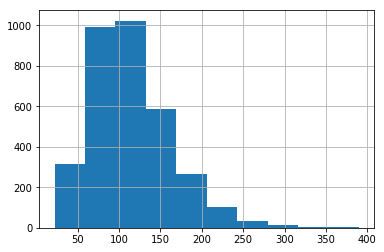

In [37]:
df['APM'].hist();

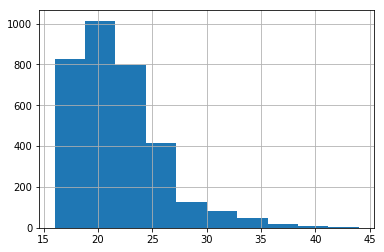

In [38]:
df['Age'].hist();

In [40]:
from sklearn.linear_model import LinearRegression

y = df['APM']
X = df.drop(columns='APM')

model = LinearRegression()
model.fit(X,y)
model.score(X,y)

0.9727919594327304

In [43]:
import matplotlib.pyplot as plt

plt.scatter(df['APM'], )

# Example 3: Birth Weight Data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight. We choose a `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Hint: mother's age likely is not simply linear in its impact, and the other features may interact as well.

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

In [19]:
bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
print(bwt_df.shape)
bwt_df.head()

(1174, 7)


,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


In [20]:
bwt_df.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


In [21]:
bwt_df.isna().sum()

bwt          0
gestation    0
parity       0
age          0
height       0
weight       0
smoke        0
dtype: int64

In [22]:
target = 'bwt'

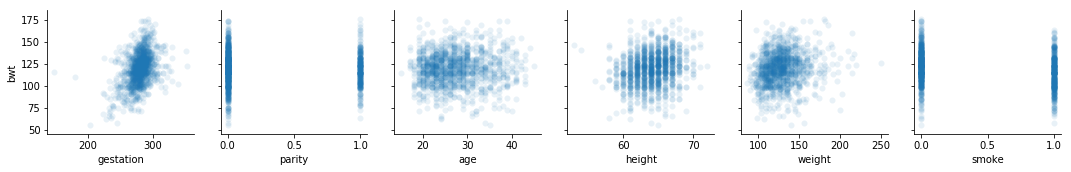

In [24]:
sns.pairplot(data=bwt_df, y_vars=target, x_vars=bwt_df.drop(columns=target).columns,
             plot_kws={'alpha': 0.1, 'linewidth':0});

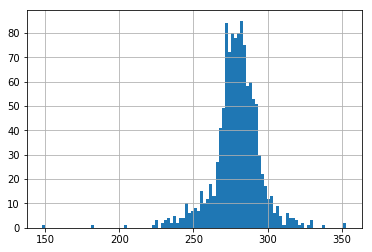

In [25]:
bwt_df['gestation'].hist(bins=100);

In [26]:
bwt_df.corr()

,bwt,gestation,parity,age,height,weight,smoke
bwt,1.000000,0.407543,-0.043908,0.026983,0.203704,0.155923,-0.246800
gestation,0.407543,1.000000,0.080916,-0.053425,0.070470,0.023655,-0.060267
parity,-0.043908,0.080916,1.000000,-0.351041,0.043543,-0.096362,-0.009599
age,0.026983,-0.053425,-0.351041,1.000000,-0.006453,0.147322,-0.067772
height,0.203704,0.070470,0.043543,-0.006453,1.000000,0.435287,0.017507
weight,0.155923,0.023655,-0.096362,0.147322,0.435287,1.000000,-0.060281
smoke,-0.246800,-0.060267,-0.009599,-0.067772,0.017507,-0.060281,1.000000


In [27]:
bwt_df.cov()

,bwt,gestation,parity,age,height,weight,smoke
bwt,335.940197,119.592464,-0.354183,2.877276,9.431521,59.255808,-2.208267
gestation,119.592464,256.329870,0.570145,-4.976270,2.850060,7.852544,-0.471036
parity,-0.354183,0.570145,0.193688,-0.898815,0.048409,-0.879319,-0.002062
age,2.877276,-4.976270,-0.898815,33.847247,-0.094834,17.771276,-0.192481
height,9.431521,2.850060,0.048409,-0.094834,6.381189,22.799007,0.021589
weight,59.255808,7.852544,-0.879319,17.771276,22.799007,429.910458,-0.610167
smoke,-2.208267,-0.471036,-0.002062,-0.192481,0.021589,-0.610167,0.238316


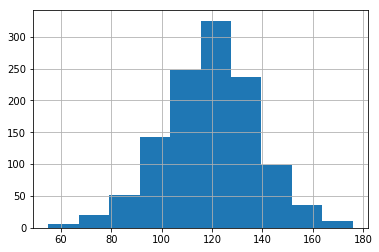

In [28]:
bwt_df['bwt'].hist();

In [64]:
q = sum(bwt_df[target] <= 90) / len(bwt_df[target])
quant_formula = target + (' ~ gestation + gestation * gestation')
print(quant_formula)
model = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = model.fit(q=q)
quant_reg.summary()

bwt ~ gestation + gestation * gestation


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1621
Model:                       QuantReg   Bandwidth:                       6.299
Method:                 Least Squares   Sparsity:                        132.1
Date:                Wed, 27 Feb 2019   No. Observations:                 1174
Time:                        18:42:15   Df Residuals:                     1172
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -50.0625     26.020     -1.924      0.055    -101.113       0.988
gestation      0.5156      0.093      5.535      0.000       0.333       0.698
==============================================================================

The condition number is large, 4.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\City_Year\Anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
C:\Users\City_Year\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
C:\Users\City_Year\Anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


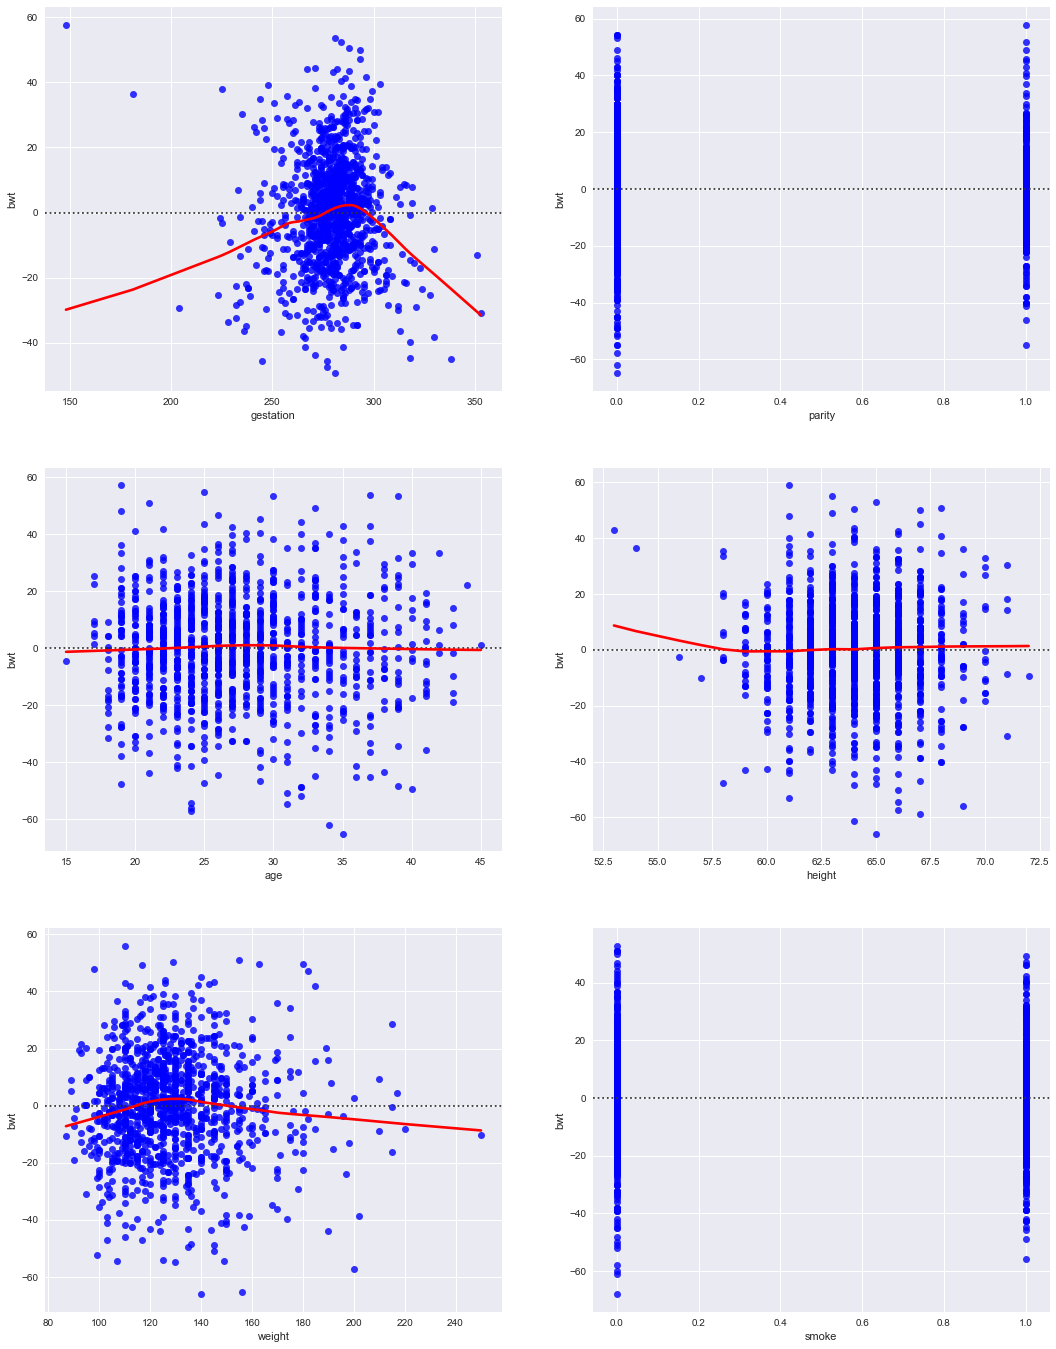

In [37]:
def ceil(a, b=1):
     return int(-(-a // b))

    
predictors = bwt_df.drop(columns=target).columns
n_plots = len(predictors)
fig, axs = plt.subplots(ncols=2, 
                        nrows=ceil(len(predictors), 2),
                        figsize=(3*n_plots,4*n_plots))

for i, col in enumerate(predictors):
    row_i = i // 2
    col_i = i % 2
    ax = axs[row_i][col_i]
    sns.residplot(bwt_df[col], bwt_df[target], lowess=True, color="r", 
                  ax=ax, scatter_kws={'color':'blue'})